# 📝 Celda 1 — Imports, rutas y semillas


Configuramos TensorFlow/Keras, rutas a secuencias del Cuaderno 4 y la semilla para reproducibilidad.

In [8]:
from pathlib import Path
import itertools, json, time, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Tuple

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Reproducibilidad
SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED)

# Rutas de los datasets secuenciales (creados en Cuaderno 4)
SEQ_ROOT = Path("../data/processed/seq")

# Directorios de salida
FIG_DIR = Path("../reports/figures")
OUT_DIR = Path("../reports/models")
FIG_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("TF:", tf.__version__)


TF: 2.20.0


# 📝 Celda 2 — Carga de secuencias (train/val/test)

Utilidades para cargar X/y y metadatos de cada ticker y window_size.

In [9]:
def load_seq(ticker: str, W: int):
    base = SEQ_ROOT / ticker / f"w{W}"
    Xtr = np.load(base / "X_train.npy"); ytr = np.load(base / "y_train.npy")
    Xva = np.load(base / "X_val.npy");   yva = np.load(base / "y_val.npy")
    Xte = np.load(base / "X_test.npy");  yte = np.load(base / "y_test.npy")
    with open(base / "meta.json", "r", encoding="utf-8") as f:
        meta = json.load(f)
    return (Xtr,ytr), (Xva,yva), (Xte,yte), meta

# Prueba rápida
for tkr in ["BBVA","SAN"]:
    for W in [10,20,30]:
        (Xtr,ytr),(Xva,yva),(Xte,yte),meta = load_seq(tkr, W)
        print(f"{tkr} W={W} -> Xtr{Xtr.shape}, Xva{Xva.shape}, Xte{Xte.shape}, feats={meta['n_features']}")


BBVA W=10 -> Xtr(4618, 10, 13), Xva(652, 10, 13), Xte(1313, 10, 13), feats=13
BBVA W=20 -> Xtr(4608, 20, 13), Xva(642, 20, 13), Xte(1303, 20, 13), feats=13
BBVA W=30 -> Xtr(4598, 30, 13), Xva(632, 30, 13), Xte(1293, 30, 13), feats=13
SAN W=10 -> Xtr(4618, 10, 13), Xva(652, 10, 13), Xte(1313, 10, 13), feats=13
SAN W=20 -> Xtr(4608, 20, 13), Xva(642, 20, 13), Xte(1303, 20, 13), feats=13
SAN W=30 -> Xtr(4598, 30, 13), Xva(632, 30, 13), Xte(1293, 30, 13), feats=13


In [10]:
# Celda 2bis — Baseline de persistencia (ŷ = último Close de la ventana)
def naive_persistence(X3: np.ndarray) -> np.ndarray:
    # asumimos Close como 1ª feature (lo es con nuestro orden actual)
    return X3[:, -1, 0]

for tkr in ["BBVA","SAN"]:
    # usa una ventana de referencia (ej. 20) solo para diagnosticar
    (Xtr,ytr),(Xva,yva),(Xte,yte),meta = load_seq(tkr, 20)
    yhat_naive = naive_persistence(Xte)
    mse_naive = np.mean((yhat_naive - yte)**2)
    print(f"{tkr} · Naive (persistencia) · MSE test = {mse_naive:.6f}")


BBVA · Naive (persistencia) · MSE test = 0.012875
SAN · Naive (persistencia) · MSE test = 0.018460


# 📝 Celda 3 — Constructor de modelos (SimpleRNN / LSTM / GRU)

Función para construir el modelo con una sola capa recurrente y cabeza densa lineal (como en el TFG). Optimización con Adam y pérdida MSE.

In [11]:
# Celda 3 — modelos apilados y sin warning (Input)
from tensorflow.keras import regularizers

def build_model(model_type: str, units: int, n_features: int, window_size: int, lr: float) -> keras.Model:
    inp = keras.Input(shape=(window_size, n_features))
    if model_type == "SimpleRNN":
        x = layers.SimpleRNN(units, return_sequences=True,
                             dropout=0.1, recurrent_dropout=0.1,
                             kernel_regularizer=regularizers.l2(1e-5))(inp)
        x = layers.SimpleRNN(units, dropout=0.1, recurrent_dropout=0.1)(x)
    elif model_type == "LSTM":
        x = layers.LSTM(units, return_sequences=True,
                        dropout=0.2, recurrent_dropout=0.2)(inp)
        x = layers.LSTM(units, dropout=0.2, recurrent_dropout=0.2)(x)
    elif model_type == "GRU":
        x = layers.GRU(units, return_sequences=True,
                       dropout=0.2, recurrent_dropout=0.2)(inp)
        x = layers.GRU(units, dropout=0.2, recurrent_dropout=0.2)(x)
    else:
        raise ValueError("model_type debe ser 'SimpleRNN', 'LSTM' o 'GRU'")
    out = layers.Dense(1)(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss="mse", metrics=["mse"])
    return model



# 📝 Celda 4 — Entrenamiento y evaluación (con EarlyStopping)

Entrenamos con EarlyStopping (paciencia 2, monitor val_loss) y devolvemos historia, métricas de val/test y predicciones para test.

In [12]:
def fit_and_eval(model_type: str, tkr: str, W: int, units: int, batch: int, lr: float, epochs: int):
    (Xtr,ytr),(Xva,yva),(Xte,yte),meta = load_seq(tkr, W)
    model = build_model(model_type, units, meta["n_features"], W, lr)
    es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    history = model.fit(
        Xtr, ytr,
        validation_data=(Xva,yva),
        epochs=epochs,
        batch_size=batch,
        verbose=0,
        callbacks=[es]
    )
    # Evaluación
    val_mse = model.evaluate(Xva, yva, verbose=0)[0]
    test_mse = model.evaluate(Xte, yte, verbose=0)[0]
    yhat_test = model.predict(Xte, verbose=0).ravel()
    return {
        "model": model,
        "history": history.history,
        "val_mse": float(val_mse),
        "test_mse": float(test_mse),
        "y_true_test": yte,
        "y_pred_test": yhat_test
    }


# 📝 Celda 5 — Curvas de pérdida (5/7/10 épocas) como en el TFG

Para cada modelo (SimpleRNN, LSTM, GRU) y cada ticker, dibujamos tres curvas de pérdida (train/val) con epochs = 5, 7, 10.
Usamos una configuración base units=64, batch=32, lr=1e-3 (mismo espíritu del TFG).

In [ ]:
BASE_CFG = dict(units=64, batch=32, lr=1e-3)
EPOCHS_LIST = [5,7,10]
MODELS = ["SimpleRNN","LSTM","GRU"]
TICKERS = ["BBVA","SAN"]
WINDOW_FOR_PLOTS = 20  # el TFG suele fijar una ventana para las curvas; puedes cambiar a 10 o 30 si prefieres

def plot_losses(histories, title):
    plt.figure(figsize=(8,5))
    for ep, h in histories.items():
        plt.plot(h["loss"], label=f"train (e={ep})")
        plt.plot(h["val_loss"], label=f"val (e={ep})", linestyle="--")
    plt.title(title); plt.xlabel("Época"); plt.ylabel("MSE (pérdida)")
    plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

for tkr in TICKERS:
    for m in MODELS:
        hist_dict = {}
        for ep in EPOCHS_LIST:
            res = fit_and_eval(m, tkr, WINDOW_FOR_PLOTS, **BASE_CFG, epochs=ep)
            hist_dict[ep] = res["history"]
        plot_losses(hist_dict, f"{tkr} · {m} — Curvas de pérdida (W={WINDOW_FOR_PLOTS})")

        # (Opcional) guarda la última figura si quieres reportarla
        # plt.savefig(FIG_DIR / f"{tkr}_{m}_loss_curves_W{WINDOW_FOR_PLOTS}.png", dpi=130)


# 📝 Celda 6 — Grid Search (MSE en validación) y ranking

Aplicamos Grid Search (exhaustivo) con los rangos del TFG y guardamos un ranking por ticker y modelo.
La métrica de selección es val_mse. Al final, re-evaluamos la mejor combinación también en test.

In [ ]:
GRID = {
    "window": [10,20,30],
    "units": [32,64,128],
    "batch": [32,64],
    "lr": [1e-3, 5e-4],
}
MAX_EPOCHS = 30  # en el TFG se prueban 5/7/10; para el grid usamos 10 con EarlyStopping

def grid_search_for_model(tkr: str, model_type: str) -> pd.DataFrame:
    rows = []
    for W, U, B, LR in itertools.product(GRID["window"], GRID["units"], GRID["batch"], GRID["lr"]):
        res = fit_and_eval(model_type, tkr, W, units=U, batch=B, lr=LR, epochs=MAX_EPOCHS)
        rows.append({
            "ticker": tkr, "model": model_type,
            "window": W, "units": U, "batch": B, "lr": LR,
            "val_mse": res["val_mse"], "test_mse": res["test_mse"]
        })
        # Guardado incremental (por si se corta la ejecución)
        pd.DataFrame(rows).to_csv(OUT_DIR / f"grid_partial_{tkr}_{model_type}.csv", index=False)
    df_rank = pd.DataFrame(rows).sort_values(["val_mse","test_mse"]).reset_index(drop=True)
    return df_rank

all_ranks = []
for tkr in TICKERS:
    for m in MODELS:
        print(f"↳ Grid Search: {tkr} · {m}")
        rank_df = grid_search_for_model(tkr, m)
        rank_df.to_csv(OUT_DIR / f"grid_{tkr}_{m}.csv", index=False)
        all_ranks.append(rank_df.assign(order=range(1, len(rank_df)+1)))

grid_all = pd.concat(all_ranks, ignore_index=True)
grid_all.head()


↳ Grid Search: BBVA · SimpleRNN
↳ Grid Search: BBVA · LSTM
↳ Grid Search: BBVA · GRU
↳ Grid Search: SAN · SimpleRNN
↳ Grid Search: SAN · LSTM
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "d:\proyectos\Caso02_Predicciones_bancos\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3579, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\lucia\AppData\Local\Temp\ipykernel_17368\925802900.py", line 27, in <module>
    rank_df = grid_search_for_model(tkr, m)
  File "C:\Users\lucia\AppData\Local\Temp\ipykernel_17368\925802900.py", line 12, in grid_search_for_model
    res = fit_and_eval(model_type, tkr, W, units=U, batch=B, lr=LR, epochs=MAX_EPOCHS)
  File "C:\Users\lucia\AppData\Local\Temp\ipykernel_17368\1628136671.py", line 5, in fit_and_eval
    history = model.fit(
  File "d:\proyectos\Caso02_Predicciones_bancos\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "d:\proyectos\Caso02_Predicciones_bancos\.venv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 125, in wrapper
    r

# 📝 Celda 7 — Top-10 por modelo y ticker (tabla para el informe)

Mostramos y guardamos la tabla Top-10 (como en el TFG) para cada combinación ticker/model.

In [ ]:
tops = []
for tkr in TICKERS:
    for m in MODELS:
        dfm = grid_all[(grid_all["ticker"]==tkr) & (grid_all["model"]==m)].sort_values(["val_mse","test_mse"]).head(10)
        dfm.to_csv(OUT_DIR / f"top10_{tkr}_{m}.csv", index=False)
        print(f"\n=== {tkr} · {m} — Top-10 (por val_mse) ===")
        display(dfm)
        tops.append(dfm.assign(kind=f"{tkr}_{m}"))

top_all = pd.concat(tops, ignore_index=True)
top_all.to_csv(OUT_DIR / "top10_all.csv", index=False)



=== BBVA · SimpleRNN — Top-10 (por val_mse) ===


,ticker,model,window,units,batch,lr,val_mse,test_mse,order
0,BBVA,SimpleRNN,20,32,32,0.0010,0.000087,0.000217,1
1,BBVA,SimpleRNN,10,128,64,0.0005,0.000095,0.000220,2
2,BBVA,SimpleRNN,10,128,32,0.0005,0.000109,0.000174,3
3,BBVA,SimpleRNN,20,32,32,0.0005,0.000110,0.000224,4
4,BBVA,SimpleRNN,30,128,64,0.0005,0.000115,0.000220,5
5,BBVA,SimpleRNN,10,128,32,0.0010,0.000126,0.000559,6
6,BBVA,SimpleRNN,10,128,64,0.0010,0.000136,0.000773,7
7,BBVA,SimpleRNN,30,64,64,0.0005,0.000145,0.000603,8
8,BBVA,SimpleRNN,30,64,32,0.0010,0.000145,0.000557,9
9,BBVA,SimpleRNN,20,64,32,0.0005,0.000160,0.000329,10



=== BBVA · LSTM — Top-10 (por val_mse) ===


,ticker,model,window,units,batch,lr,val_mse,test_mse,order
36,BBVA,LSTM,10,64,32,0.0010,0.000045,0.000118,1
37,BBVA,LSTM,30,128,32,0.0010,0.000051,0.000114,2
38,BBVA,LSTM,30,64,32,0.0005,0.000052,0.000111,3
39,BBVA,LSTM,10,32,32,0.0005,0.000061,0.000209,4
40,BBVA,LSTM,30,128,32,0.0005,0.000062,0.000142,5
41,BBVA,LSTM,20,128,32,0.0010,0.000062,0.000185,6
42,BBVA,LSTM,30,32,64,0.0005,0.000069,0.000404,7
43,BBVA,LSTM,10,128,32,0.0005,0.000075,0.000138,8
44,BBVA,LSTM,10,128,64,0.0005,0.000078,0.000154,9
45,BBVA,LSTM,10,64,32,0.0005,0.000082,0.000151,10



=== BBVA · GRU — Top-10 (por val_mse) ===


,ticker,model,window,units,batch,lr,val_mse,test_mse,order
72,BBVA,GRU,10,64,32,0.0005,0.000039,0.000100,1
73,BBVA,GRU,30,128,32,0.0010,0.000039,0.000103,2
74,BBVA,GRU,30,128,32,0.0005,0.000040,0.000102,3
75,BBVA,GRU,10,128,32,0.0005,0.000041,0.000110,4
76,BBVA,GRU,20,128,32,0.0010,0.000042,0.000109,5
77,BBVA,GRU,30,64,64,0.0010,0.000042,0.000101,6
78,BBVA,GRU,10,128,32,0.0010,0.000042,0.000146,7
79,BBVA,GRU,10,64,32,0.0010,0.000043,0.000131,8
80,BBVA,GRU,10,128,64,0.0005,0.000043,0.000133,9
81,BBVA,GRU,20,128,64,0.0005,0.000047,0.000123,10



=== SAN · SimpleRNN — Top-10 (por val_mse) ===


,ticker,model,window,units,batch,lr,val_mse,test_mse,order
108,SAN,SimpleRNN,20,128,32,0.0005,0.000098,0.000135,1
109,SAN,SimpleRNN,10,128,32,0.0010,0.000103,0.000098,2
110,SAN,SimpleRNN,10,128,64,0.0010,0.000111,0.000126,3
111,SAN,SimpleRNN,30,64,32,0.0005,0.000112,0.000168,4
112,SAN,SimpleRNN,20,64,32,0.0010,0.000126,0.000143,5
113,SAN,SimpleRNN,10,128,32,0.0005,0.000130,0.000138,6
114,SAN,SimpleRNN,30,128,64,0.0010,0.000133,0.000136,7
115,SAN,SimpleRNN,30,32,32,0.0010,0.000142,0.000130,8
116,SAN,SimpleRNN,20,32,32,0.0010,0.000144,0.000195,9
117,SAN,SimpleRNN,20,128,32,0.0010,0.000149,0.000139,10



=== SAN · LSTM — Top-10 (por val_mse) ===


,ticker,model,window,units,batch,lr,val_mse,test_mse,order
144,SAN,LSTM,30,32,64,0.0010,0.000084,0.000100,1
145,SAN,LSTM,20,128,32,0.0010,0.000098,0.000097,2
146,SAN,LSTM,30,128,64,0.0010,0.000102,0.000109,3
147,SAN,LSTM,10,128,32,0.0005,0.000103,0.000089,4
148,SAN,LSTM,30,64,32,0.0010,0.000105,0.000103,5
149,SAN,LSTM,30,64,64,0.0010,0.000106,0.000150,6
150,SAN,LSTM,10,128,32,0.0010,0.000108,0.000105,7
151,SAN,LSTM,30,128,32,0.0005,0.000115,0.000109,8
152,SAN,LSTM,20,128,64,0.0010,0.000115,0.000113,9
153,SAN,LSTM,20,64,32,0.0010,0.000115,0.000114,10



=== SAN · GRU — Top-10 (por val_mse) ===


,ticker,model,window,units,batch,lr,val_mse,test_mse,order
180,SAN,GRU,20,128,64,0.0005,0.000044,0.000057,1
181,SAN,GRU,30,128,32,0.0010,0.000044,0.000061,2
182,SAN,GRU,10,128,64,0.0010,0.000046,0.000060,3
183,SAN,GRU,30,32,32,0.0005,0.000047,0.000059,4
184,SAN,GRU,10,32,32,0.0010,0.000049,0.000068,5
185,SAN,GRU,20,128,32,0.0005,0.000049,0.000067,6
186,SAN,GRU,20,128,64,0.0010,0.000049,0.000062,7
187,SAN,GRU,20,128,32,0.0010,0.000051,0.000069,8
188,SAN,GRU,20,64,32,0.0005,0.000053,0.000065,9
189,SAN,GRU,30,64,32,0.0005,0.000055,0.000071,10


# 📝 Celda 8 — Selección del mejor por modelo (para las gráficas “real vs predicho”)

Elegimos la mejor configuración (mínimo val_mse) para cada ticker/model, reentrenamos (EarlyStopping) y graficamos real vs predicho en test.

d:\proyectos\Caso02_Predicciones_bancos\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


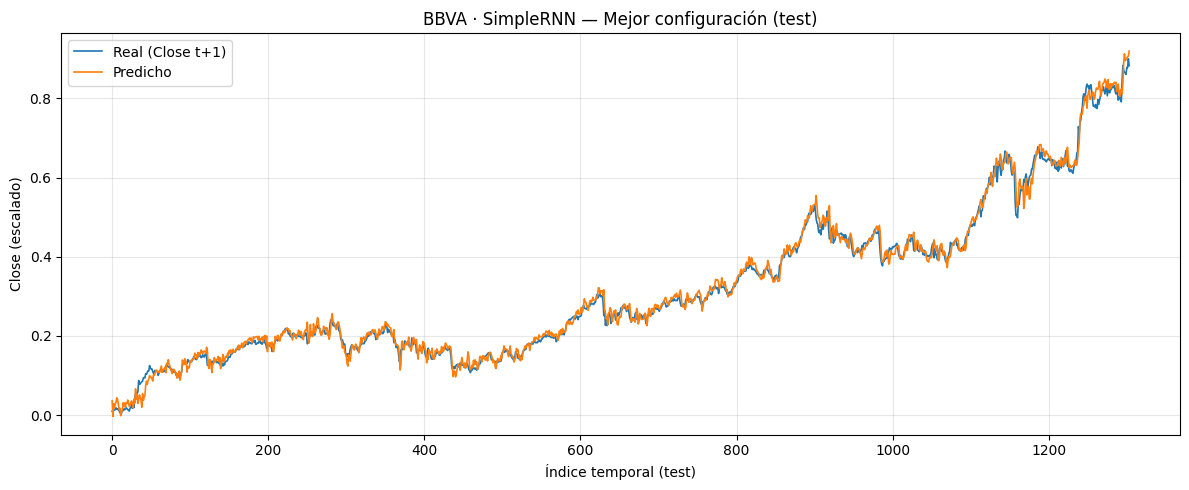

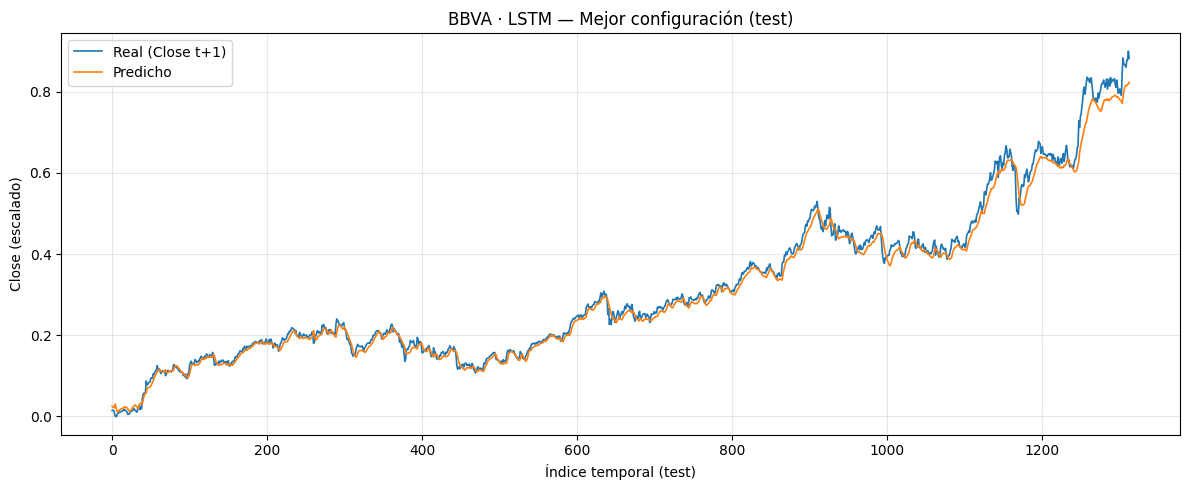

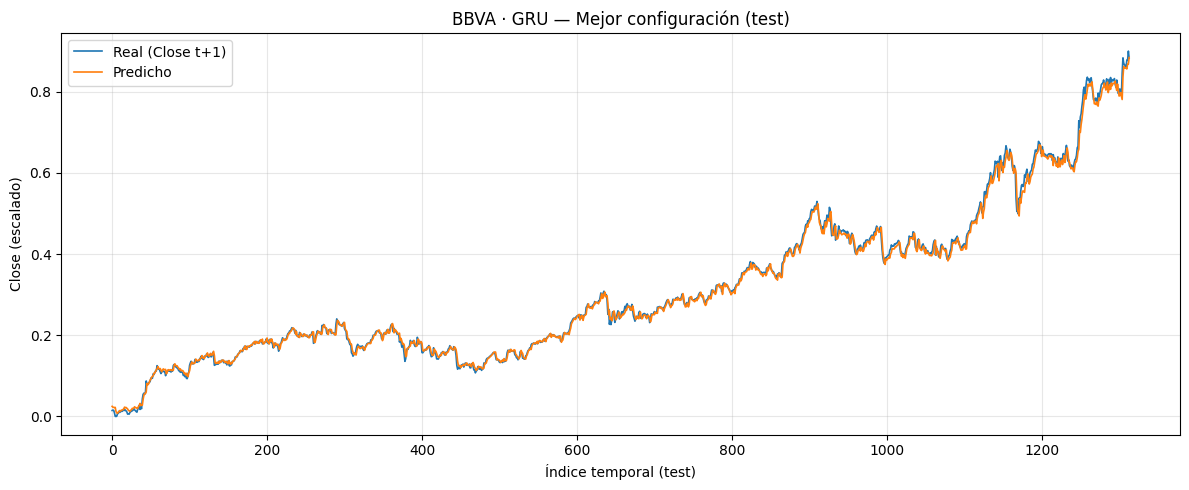

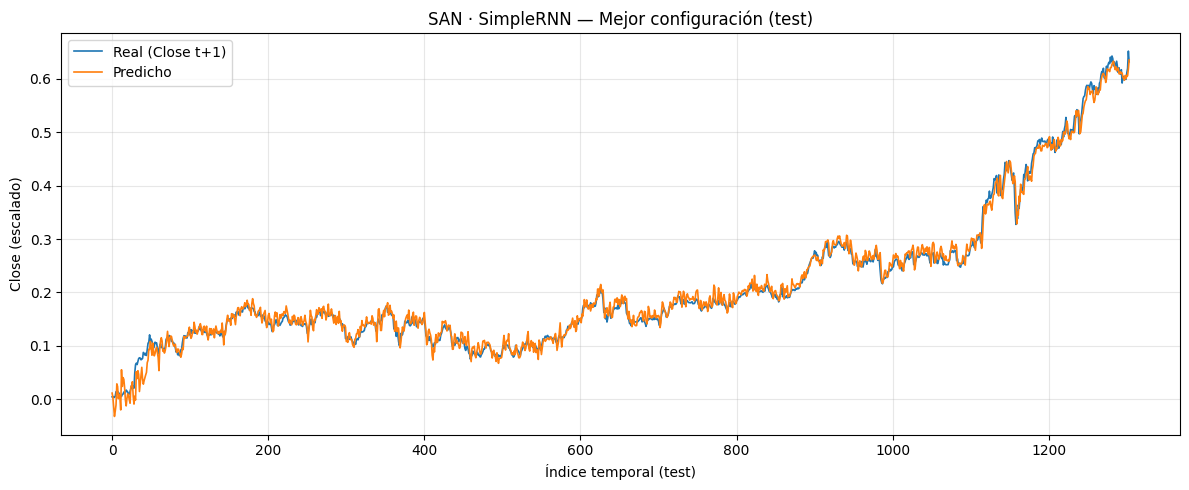

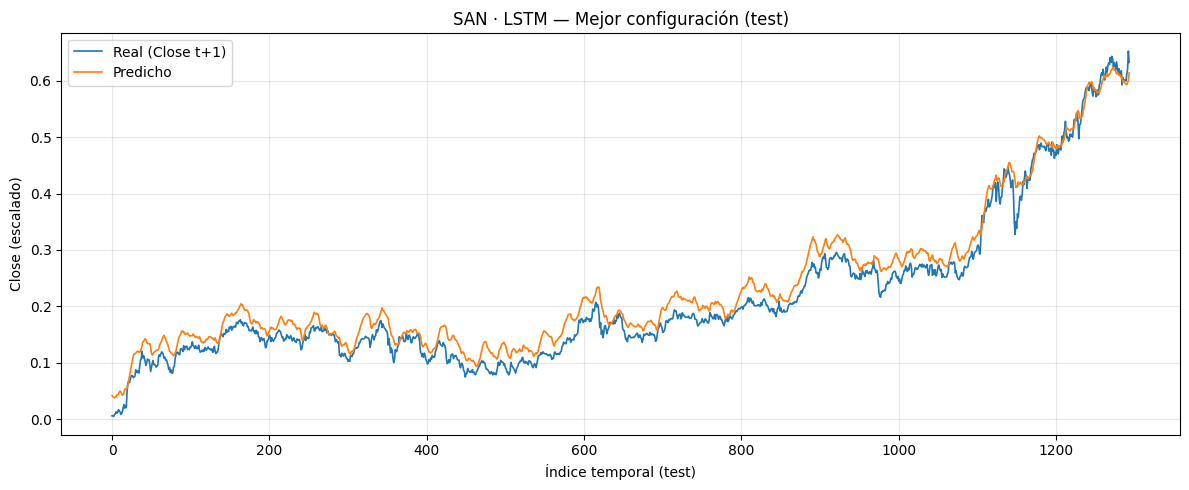

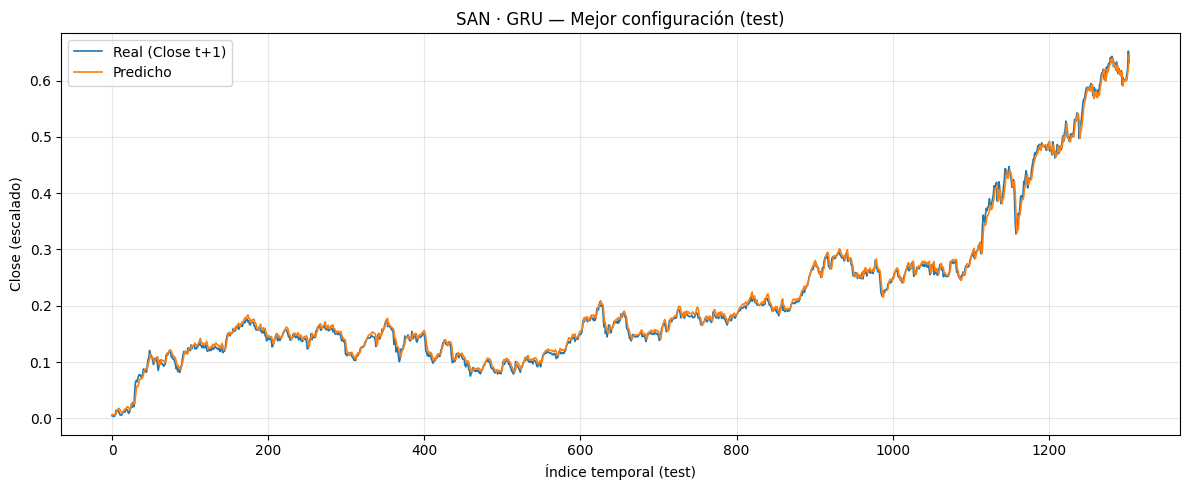

,ticker,model,window,units,batch,lr,val_mse,test_mse
2,BBVA,GRU,10,64,32,0.0005,0.000046,0.000113
0,BBVA,SimpleRNN,20,32,32,0.0010,0.000198,0.000259
1,BBVA,LSTM,10,64,32,0.0010,0.000076,0.000413
5,SAN,GRU,20,128,64,0.0005,0.000054,0.000067
3,SAN,SimpleRNN,20,128,32,0.0005,0.000142,0.000160
4,SAN,LSTM,30,32,64,0.0010,0.000346,0.000656


In [ ]:
def best_config(df: pd.DataFrame, tkr: str, m: str):
    sub = df[(df["ticker"]==tkr) & (df["model"]==m)].sort_values(["val_mse","test_mse"]).head(1).iloc[0]
    return dict(W=int(sub["window"]), U=int(sub["units"]), B=int(sub["batch"]), LR=float(sub["lr"]))

def plot_real_pred(y_true, y_pred, title):
    plt.figure(figsize=(12,5))
    plt.plot(y_true, label="Real (Close t+1)", linewidth=1.2)
    plt.plot(y_pred, label="Predicho", linewidth=1.2)
    plt.title(title); plt.xlabel("Índice temporal (test)"); plt.ylabel("Close (escalado)")
    plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

best_runs = []
for tkr in TICKERS:
    for m in MODELS:
        cfg = best_config(grid_all, tkr, m)
        res = fit_and_eval(m, tkr, cfg["W"], cfg["U"], cfg["B"], cfg["LR"], epochs=MAX_EPOCHS)
        plot_real_pred(res["y_true_test"], res["y_pred_test"], f"{tkr} · {m} — Mejor configuración (test)")
        best_runs.append({
            "ticker": tkr, "model": m, "window": cfg["W"], "units": cfg["U"],
            "batch": cfg["B"], "lr": cfg["LR"], "val_mse": res["val_mse"], "test_mse": res["test_mse"]
        })

best_table = pd.DataFrame(best_runs).sort_values(["ticker","test_mse"])
best_table.to_csv(OUT_DIR / "best_models_summary.csv", index=False)
best_table


In [ ]:
# Celda 8bis — mejora vs persistencia para los mejores
def mse(a,b): return float(np.mean((a-b)**2))

for row in best_table.itertuples(index=False):
    (Xtr,ytr),(Xva,yva),(Xte,yte),meta = load_seq(row.ticker, int(row.window))
    # recomputa yhat del mejor modelo
    model = build_model(row.model, int(row.units), meta["n_features"], int(row.window), float(row.lr))
    es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    model.fit(Xtr, ytr, validation_data=(Xva,yva), epochs=MAX_EPOCHS, batch_size=int(row.batch), verbose=0, callbacks=[es])
    yhat = model.predict(Xte, verbose=0).ravel()
    ynaive = naive_persistence(Xte)
    mse_model = mse(yte, yhat)
    mse_naive = mse(yte, ynaive)
    imp = 100*(1 - mse_model/mse_naive)
    print(f"{row.ticker} · {row.model} (W={row.window}, U={row.units}) → MSE={mse_model:.6f} | Naive={mse_naive:.6f} | Mejora={imp:.2f}%")


# 📝 Celda 9 — Comparativa final de MSE (barras)

Gráfico de barras comparando el MSE de test de los mejores modelos (SimpleRNN vs LSTM vs GRU) para cada ticker.

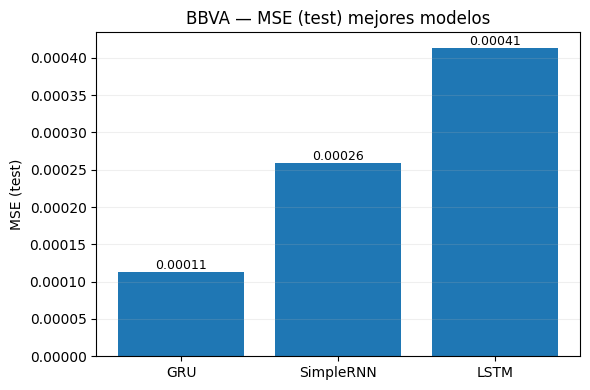

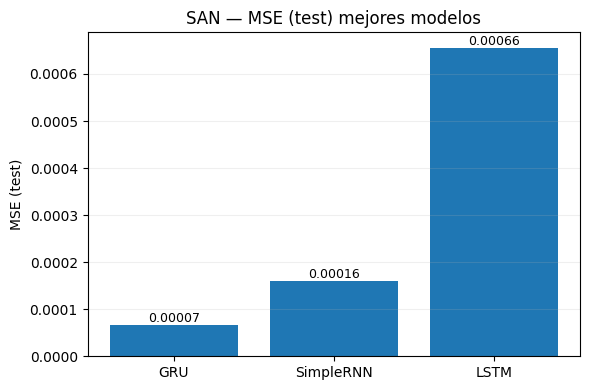

In [ ]:
def bar_compare(best_table, ticker):
    sub = best_table[best_table["ticker"]==ticker].sort_values("test_mse")
    plt.figure(figsize=(6,4))
    plt.bar(sub["model"], sub["test_mse"])
    for i,(m,v) in enumerate(zip(sub["model"], sub["test_mse"])):
        plt.text(i, v, f"{v:.5f}", ha="center", va="bottom", fontsize=9)
    plt.title(f"{ticker} — MSE (test) mejores modelos")
    plt.ylabel("MSE (test)"); plt.grid(axis="y", alpha=0.2)
    plt.tight_layout(); plt.show()

for tkr in TICKERS:
    bar_compare(best_table, tkr)


# 📝 Celda 10 — Guardado opcional de modelos (H5)

Si quieres conservar los pesos de los mejores para incluirlos en el repo/entrega:

In [ ]:
SAVE_MODELS = True

if SAVE_MODELS:
    for row in best_table.itertuples(index=False):
        (Xtr,ytr),(Xva,yva),(Xte,yte),meta = load_seq(row.ticker, int(row.window))
        model = build_model(row.model, int(row.units), meta["n_features"], int(row.window), float(row.lr))
        es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        model.fit(Xtr, ytr, validation_data=(Xva,yva), epochs=MAX_EPOCHS, batch_size=int(row.batch), verbose=0, callbacks=[es])
        path = OUT_DIR / f"{row.ticker}_{row.model}_w{row.window}_u{row.units}_b{row.batch}_lr{row.lr}.h5"
        model.save(path)
        print("💾 Guardado:", path)


d:\proyectos\Caso02_Predicciones_bancos\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


💾 Guardado: ..\reports\models\BBVA_GRU_w10_u64_b32_lr0.0005.h5


💾 Guardado: ..\reports\models\BBVA_SimpleRNN_w20_u32_b32_lr0.001.h5


💾 Guardado: ..\reports\models\BBVA_LSTM_w10_u64_b32_lr0.001.h5


💾 Guardado: ..\reports\models\SAN_GRU_w20_u128_b64_lr0.0005.h5


💾 Guardado: ..\reports\models\SAN_SimpleRNN_w20_u128_b32_lr0.0005.h5


💾 Guardado: ..\reports\models\SAN_LSTM_w30_u32_b64_lr0.001.h5


## 📝 Resumen



- Curvas de pérdida (5/7/10 épocas) para SimpleRNN, LSTM y GRU en BBVA y SAN (W=20).

- Grid Search con hiperparámetros del TFG:

window_size = 10, 20, 30

units = 32, 64, 128

batch_size = 32, 64

learning_rate = 0.001, 0.0005

- Métrica de selección: MSE (validación).

- Top-10 por ticker/model (CSV en reports/models).

- Mejores configuraciones reentrenadas y evaluadas en test con gráficas “real vs predicho”.

- Barras comparativas de MSE (SimpleRNN vs LSTM vs GRU) por ticker.

- Modelos guardados (.h5) para reproducibilidad.